In [103]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal.windows as win

In [104]:
sample_freq = 44100
abtast_interval = 1/sample_freq

In [105]:
def read_audio(file: str):
    data = np.load(file)
    return data / 1e8

(112640,)
0.20070724899122902


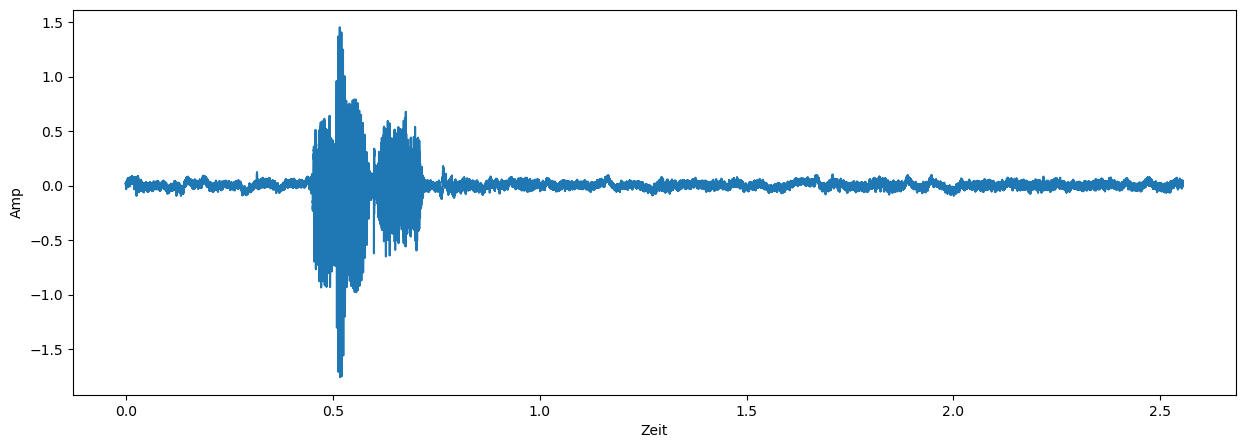

In [106]:
audio_file = "./aufnahme/kevin/links/links_0.npy"
test_signal = read_audio(audio_file)
print(test_signal.shape)

fig, ax = plt.subplots(figsize=(15,5))
ax.set_ylabel("Amp")
ax.set_xlabel("Zeit")

ax.plot(np.linspace(0,len(test_signal)/sample_freq,num=len(test_signal)), test_signal)

cutoff_point = np.std(test_signal) * 1.7
print(cutoff_point)

In [107]:
def read_audio(file: str):
    data = np.load(file)
    cutoff_point = np.std(data) * 2.2
    start_index = np.argmax((data > cutoff_point) | (data < -cutoff_point))
    end_index = start_index + sample_freq # 44100 sample freq
    return data[start_index:end_index] / 1e8

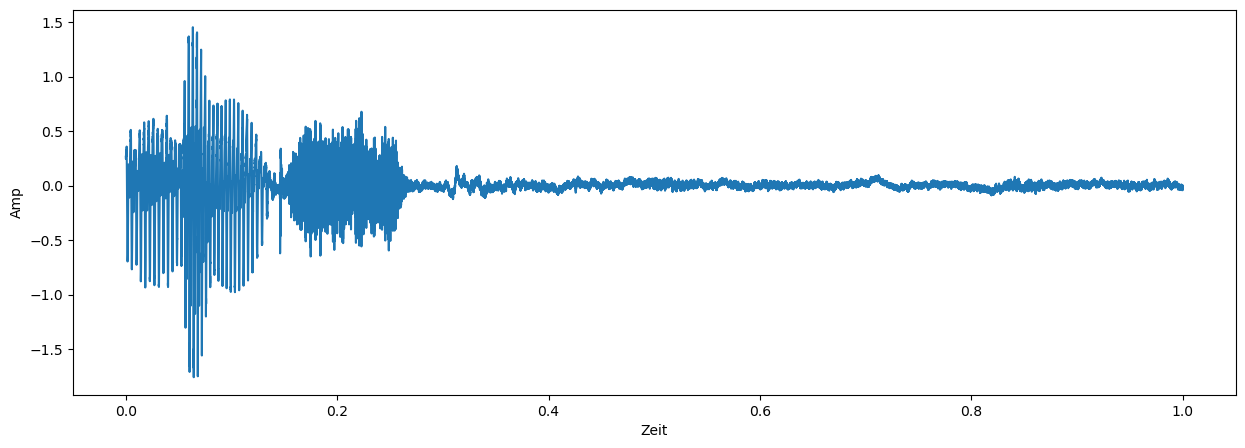

In [108]:
cut = read_audio(audio_file)

fig, ax = plt.subplots(figsize=(15,5))
ax.set_ylabel("Amp")
ax.set_xlabel("Zeit")
ax.plot(np.linspace(0, 1, num=sample_freq), cut)

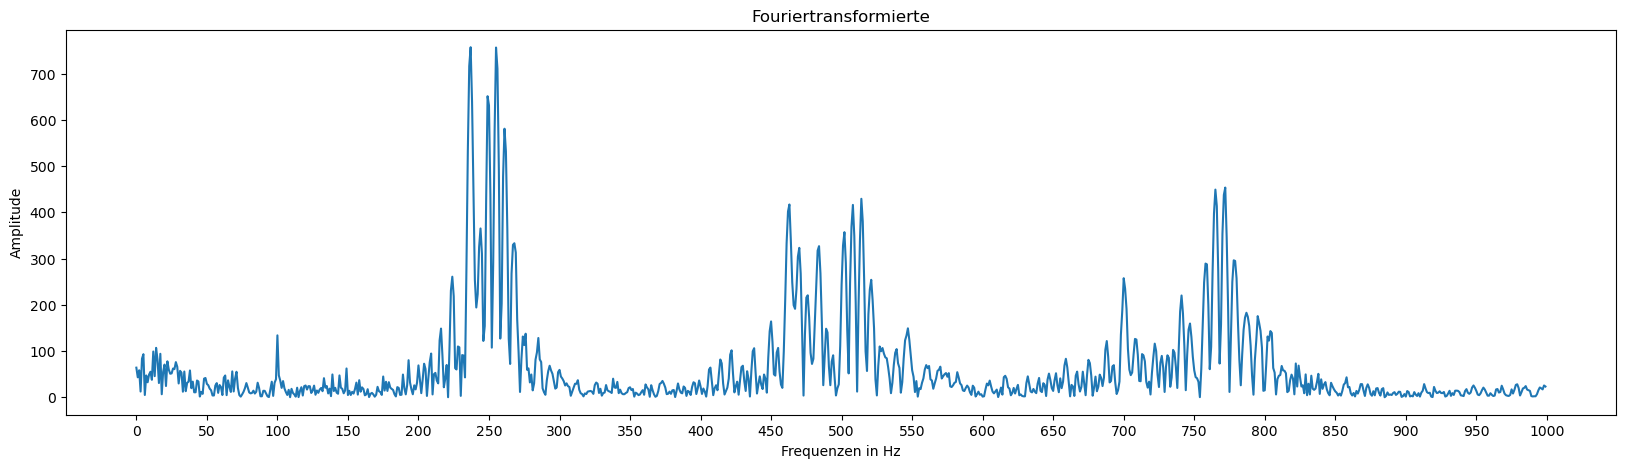

In [109]:
F = np.fft.fft(cut)
freq = np.fft.fftfreq(cut.size, d=abtast_interval)

fig, axl = plt.subplots(figsize=(20, 5))

freqc = freq[:1000]
Fc = F.real[:1000]
axl.set_title("Fouriertransformierte")
axl.set_xlabel("Frequenzen in Hz")
axl.set_ylabel("Amplitude")
axl.locator_params(axis="x", nbins=40)
axl.plot(freqc, np.abs(Fc))

# Windows

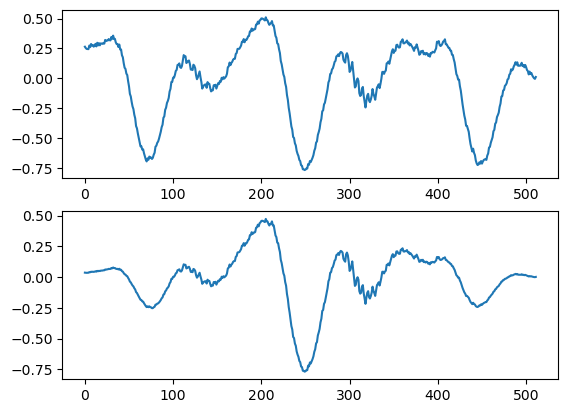

In [110]:
fig, (ax1, ax2) = plt.subplots(2)
window = win.gaussian(512, 512/4)
ax1.plot(cut[:512])
ax2.plot(cut[:512]*window)

In [111]:
def windows(signal):
    F_segments = []

    part = 512
    while part < signal.size:
        w = signal[part-512:part] * window
        F_segments.append(np.abs(np.fft.fft(w)))
        part += 256

    return np.array(F_segments).mean(axis=0)

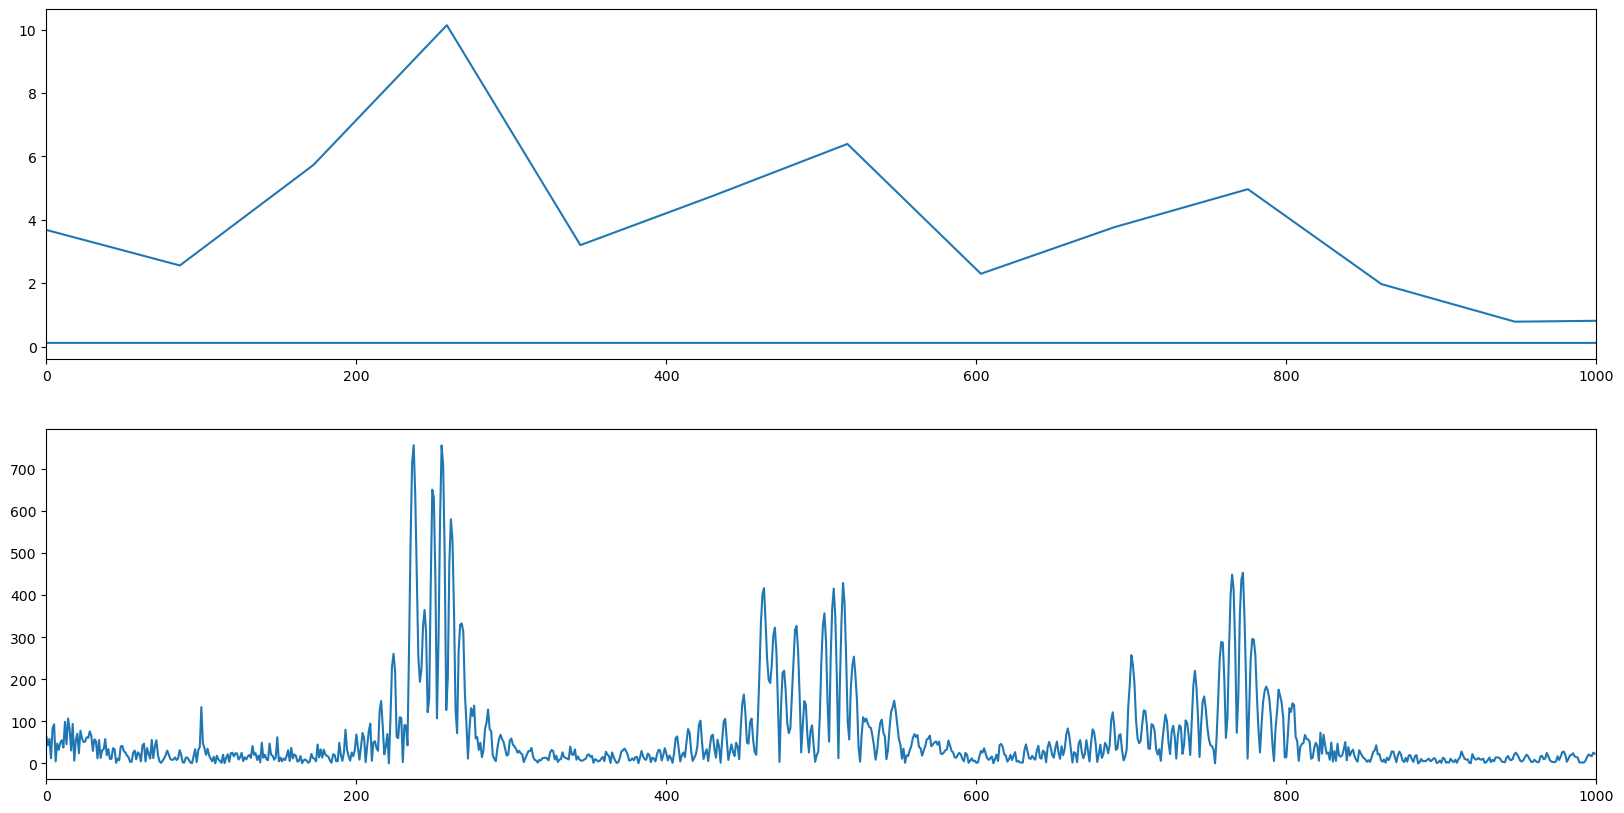

In [112]:
abtastintervall = (512/44100) / 512
F_hz = np.fft.fftfreq(512, d=abtastintervall)

fig,(ax1,ax2) = plt.subplots(2, figsize=(20,10))

ax2.set_xlim(0, 1000)
ax2.plot(freqc, np.abs(Fc))

freqc1 = F_hz[:1000]
sec = windows(cut)
Fc1 = sec.real[:1000]

ax1.set_xlim(0, 1000)
ax1.plot(freqc1, np.abs(Fc1))

# 2 Spracherkennung

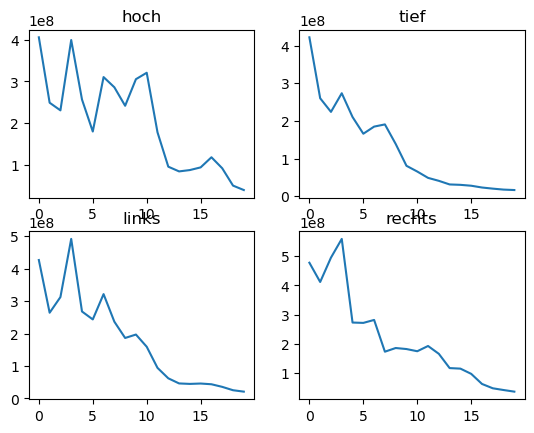

In [113]:

befehle = ["hoch", "tief", "links", "rechts"]

ref_dict = {}
for idx_befehl, befehl in enumerate(befehle):
    ref_dict[befehl] = []
    for i in range(5):
        data = np.load(f"aufnahme/kevin/{befehl}/{befehl}_{i}.npy")
        ref_dict[befehl].append(windows(data))
    ref_dict[befehl] = np.array(ref_dict[befehl]).mean(axis=0)
    plt.subplot(2, 2, idx_befehl + 1)
    plt.plot(ref_dict[befehl][:20])
    plt.title(befehl)

plt.show()

Testdatensätze

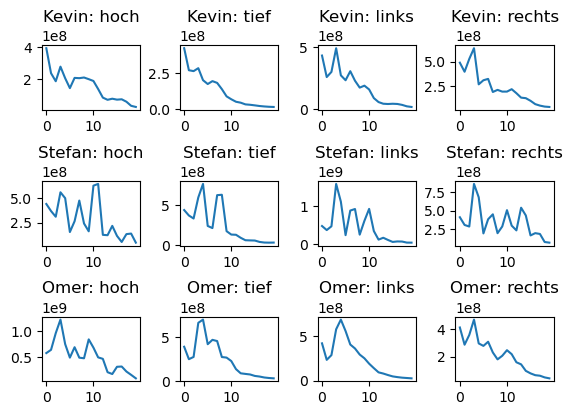

In [114]:
tests_dict = {}
namen = ["kevin", "stefan", "omer"]

for idx_name, name in enumerate(namen):
    tests_dict[name] = {}
    for idx_befehl, befehl in enumerate(befehle):
        tests_dict[name][befehl] = []
        for i in range(3):
            data = np.load(f"aufnahme/{name}/{befehl}/{befehl}_{i}.npy")
            tests_dict[name][befehl].append(windows(data))
        tests_dict[name][befehl] = np.array(tests_dict[name][befehl]).mean(axis=0)
        plt.subplot(3, 4, idx_name*4 + idx_befehl + 1)
        plt.plot(tests_dict[name][befehl][:20])
        plt.title(f"{name.title()}: {befehl}")

plt.subplots_adjust(0.1,0.2,0.9,0.9,0.4,1.1)
plt.show()

Korrelation

In [115]:
def std_ab(d):
    mean = np.mean(d)
    return np.sqrt(sum(np.power(x - mean, 2) for x in d) / len(d))

def get_korr(input, ref):
    xMean = np.mean(input)
    yMean = np.mean(ref)
    length = len(input)
    kovarianz = sum((x - xMean) * (y - yMean)for x, y in zip(input, ref)) / length
    return kovarianz / (std_ab(input) * std_ab(ref))

Vergleich

In [116]:
korr_dict = {}
for befehl in befehle:
    korr_dict[befehl] = {}
    ref = ref_dict[befehl]
    for name in namen:
        korr_dict[befehl][name] = get_korr(tests_dict[name][befehl], ref)


for befehl, names in korr_dict.items():
    for name, korr in names.items():
        print(f"{name} mit Befehlt {befehl} korreliert mit {korr}")


kevin mit Befehlt hoch korreliert mit 0.9852246885468875
stefan mit Befehlt hoch korreliert mit 0.8984536405993546
omer mit Befehlt hoch korreliert mit 0.9537531165959727
kevin mit Befehlt tief korreliert mit 0.9972232823879692
stefan mit Befehlt tief korreliert mit 0.8715247251522155
omer mit Befehlt tief korreliert mit 0.8915298107519966
kevin mit Befehlt links korreliert mit 0.9992650597043843
stefan mit Befehlt links korreliert mit 0.8879426249390511
omer mit Befehlt links korreliert mit 0.9227215962542856
kevin mit Befehlt rechts korreliert mit 0.9973584036850908
stefan mit Befehlt rechts korreliert mit 0.8253352665871785
omer mit Befehlt rechts korreliert mit 0.9607198765816666


Testdaten vergleich mit allen Referenzen

In [117]:
# befehl_dict {"hoch", daten, "rechts", daten, usw.}
for name, befehl_dict in tests_dict.items():
    score = 0
    print(f"{name.title()}:")

    for befehl, testDaten in befehl_dict.items():
        korrs = []
        # ref_befehl = welcher befehl (zb. "hoch"), ref = refDaten
        for ref_befehl, ref in ref_dict.items():
            korrs.append((ref_befehl, get_korr(testDaten, ref)))
        korrs.sort(key=lambda t: t[1], reverse=True)
        print(f"{befehl.title()} -> {korrs[0][0].title()}: {korrs[0][1]}")
        if befehl == korrs[0][0]:
            score += 1
    print(f"{score}/4 korrekt")

Kevin:
Hoch -> Hoch: 0.9852246885468875
Tief -> Tief: 0.9972232823879692
Links -> Links: 0.9992650597043843
Rechts -> Rechts: 0.9973584036850908
4/4 korrekt
Stefan:
Hoch -> Hoch: 0.8984536405993546
Tief -> Tief: 0.8715247251522155
Links -> Hoch: 0.898170057820446
Rechts -> Hoch: 0.8787925524559411
2/4 korrekt
Omer:
Hoch -> Hoch: 0.9537531165959727
Tief -> Links: 0.9326644689053714
Links -> Links: 0.9227215962542856
Rechts -> Links: 0.9647995699092065
2/4 korrekt
